<a href="https://colab.research.google.com/github/AlexSoldatov/AI-Study/blob/main/%D0%94%D0%97_2ULTRAPRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание № 2 Ultra-PRO**

In [9]:
# Импорт библиотек
from tensorflow.keras.models import Sequential # импорт конструктора НС прямого распространения 
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Импорт используемых слоев
from tensorflow.keras import utils # импорт утилит для to_categorical
from tensorflow.keras.preprocessing import image # импорт для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # импорт алгоритмов оптимизации, для настройки скорости обучения
import numpy as np # импорт библиотеки работы с массивами
import matplotlib.pyplot as plt # импорт библиотеки для отрисовка изображений
from PIL import Image # импорт библиотеки для отрисовка изображений
import pandas as pd # импорт библиотеки pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping # подключаем колбэки
# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

# **Загрузка и обработка файла**

In [10]:
# Считываем csv с помощью pandas
path_car = '/content/drive/MyDrive/Занятия/2/cars_new.csv'
cars = pd.read_csv(path_car, sep=',')
cars[:5] # Выводим первые 5 машин 

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [11]:
print(cars.values.shape)

(70119, 10)


In [12]:
# Функция создания словаря, поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [13]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [14]:
# Дя примера выводим словарь 'mark'
print(marks_dict)

{'chevrolet': 0, 'audi': 1, 'bmw': 2, 'suzuki': 3, 'subaru': 4, 'toyota': 5, 'daewoo': 6, 'volkswagen': 7, 'skoda': 8, 'honda': 9, 'mitsubishi': 10, 'mazda': 11, 'opel': 12, 'mercedes-benz': 13, 'nissan': 14, 'renault': 15, 'hyundai': 16, 'ford': 17, 'peugeot': 18, 'kia': 19, 'chery': 20}


In [15]:
# Для примера выводим нормированное значение
years.mean()

7.129646144783743e-15

In [16]:
years.std()

1.0

In [17]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [20]:
# Создаем обучающую выборку
# Создаём пустую обучающую выборку
x_train_base = []
y_train_base = []

# Проходим по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train_base.append(prices[_id])
  
  # В x_train_base объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  # Добавляем текущую строку в общий x_train_base
  x_train_base.append(x_tr)

# Превращаем лист в numpy.array
x_train_base = np.array(x_train_base, dtype=np.float)
y_train_base = np.array(y_train_base, dtype=np.float)

In [21]:
# Вывод размеров выборок
print(x_train_base.shape)
print(y_train_base.shape)

(70119, 3208)
(70119,)


In [22]:
# Проверочный вывод одного x_train_base
print(x_train_base[0,:20])
print(x_train_base[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[ 1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  1.          0.          0.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [23]:
# Проверочный вывод y_train_base
print(y_train_base[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [14]:
# Нормализация y_train_base
y_scaler = StandardScaler()
y_train_base_scaled = y_scaler.fit_transform(y_train_base.reshape(-1,1)).flatten()

# y_train_base.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [15]:
y_train_base_scaled.shape

(70119,)

In [16]:
# Вывод базового и нормированного y_train
print(y_train_base[:10])
print(y_train_base_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


# **Разделение на обучающую и тестовую выборки**

In [20]:
# sklearn - популярная библиотека для машинного обучения
# train_test_split - функция разделения на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split


# test_size=0.2 - будет выделено 20% от тренировочных данных 
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
x_train, x_test, y_train, y_test = train_test_split(x_train_base, y_train_base_scaled, test_size=0.2, shuffle=True)    
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(56095, 3208)
(14024, 3208)
(56095,)
(14024,)


# **Создание сети**

In [21]:
# Функция пересоздания пустой сети
def createModel():

  # Создаем сеть
  model = Sequential()

  # Добавляем слои
  model.add(Dense(5000, input_dim=3208, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(3000,  activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1000,  activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(100, activation='linear'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='linear'))

  # Компилируем сеть
  model.compile(loss='mse', optimizer=Adam(lr=0.001))

  return model # Возвращаем созданную сеть

# **Создание проверочной выборки**

In [22]:
epochs = 20  # число эпох для обучения
patienceStop = round(epochs/5)  #через сколько эпох остановим обучение, если нет развития
patienceReduce = round(epochs/25) #через сколько эпох понизим lr (шаг обучения)

# функция для колбека по понижению lr
reduce_lr = ReduceLROnPlateau(verbose=1, monitor='val_loss',patience=patienceReduce,min_lr=0.00001,factor=0.3)
# функция для остановки обучения и сохранения лучших весов
earlystopper = EarlyStopping(patience=patienceStop, verbose=1, monitor='val_loss',restore_best_weights=True)


In [23]:
# Создаём пустую сеть
model_ula = createModel()

# Обучаем сеть
history = model_ula.fit(x_train, 
          y_train,
          batch_size=200, 
          epochs=epochs,
          validation_split=0.2, # Указываем 20% случайных примеров для проверочной выборки
          verbose=1,
          callbacks=[reduce_lr,earlystopper])

Epoch 1/20
225/225 [==============================] - 7s 18ms/step - loss: 1.6553 - val_loss: 0.2838
Epoch 2/20
225/225 [==============================] - 4s 17ms/step - loss: 0.2131 - val_loss: 0.1118
Epoch 3/20
225/225 [==============================] - 4s 17ms/step - loss: 0.2048 - val_loss: 0.1597

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/20
225/225 [==============================] - 4s 17ms/step - loss: 0.1340 - val_loss: 0.0714
Epoch 5/20
225/225 [==============================] - 4s 17ms/step - loss: 0.0988 - val_loss: 0.0607
Epoch 6/20
225/225 [==============================] - 4s 17ms/step - loss: 0.0799 - val_loss: 0.1182

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 7/20
225/225 [==============================] - 4s 17ms/step - loss: 0.0762 - val_loss: 0.0690

Epoch 00007: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 8/20
225/225 [==============================

In [24]:
model_ula.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5000)              16045000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3000)              15003000  
_________________________________________________________________
dropout_4 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [25]:
# Сохраняем модель и загружаем ее
model_ula.save_weights('model-dz-2.h5')
model_ula.load_weights('model-dz-2.h5')

# **Проверка качества обучения на тестовом наборе данных**

In [26]:
 # Вычисление результатов работы сети на тестовом наборе
scores = model_ula.evaluate(x_test, y_test, verbose=1)
# Поскольку не используем метрику
# scores состоит из одного знанчения
# scores - loss сети на тестовой выборке
print(scores)
print("Ошибка на тестовых данных, в процентах: ", round(scores * 100, 4), "%", sep="")

439/439 [==============================] - 1s 2ms/step - loss: 0.0937
0.0936698243021965
Ошибка на тестовых данных, в процентах: 9.367%


# **Визуализация качества обучения**

In [27]:
# Просмотр ключей в структуре history
print(history.history.keys())

dict_keys(['loss', 'val_loss', 'lr'])


In [28]:
# Значения loss на обучающей выборке по эпохам
history.history['loss']

[0.571391761302948,
 0.19571688771247864,
 0.1589394211769104,
 0.10113959014415741,
 0.08900261670351028,
 0.08717981725931168,
 0.06580062210559845,
 0.05977218598127365,
 0.0618864968419075]

In [29]:
# Значения точности распознавания на проверочной выборке по эпохам
val_acc = history.history['val_loss']
train_loss = history.history['loss']
for i in range(len(val_acc)):
  print("Эпоха: ", i, "  Ошибка на учебной выборке: ", round(100 * train_loss[i], 1),"% ",\
        "  Ошибка на ппроверочной выборке: ", round(100 * val_acc[i], 1), "%", sep="")
  # round - округление
  # sep="" - убрать стандартный разделитель пробел при выводе строки

Эпоха: 0  Ошибка на учебной выборке: 57.1%   Ошибка на ппроверочной выборке: 28.4%
Эпоха: 1  Ошибка на учебной выборке: 19.6%   Ошибка на ппроверочной выборке: 11.2%
Эпоха: 2  Ошибка на учебной выборке: 15.9%   Ошибка на ппроверочной выборке: 16.0%
Эпоха: 3  Ошибка на учебной выборке: 10.1%   Ошибка на ппроверочной выборке: 7.1%
Эпоха: 4  Ошибка на учебной выборке: 8.9%   Ошибка на ппроверочной выборке: 6.1%
Эпоха: 5  Ошибка на учебной выборке: 8.7%   Ошибка на ппроверочной выборке: 11.8%
Эпоха: 6  Ошибка на учебной выборке: 6.6%   Ошибка на ппроверочной выборке: 6.9%
Эпоха: 7  Ошибка на учебной выборке: 6.0%   Ошибка на ппроверочной выборке: 7.1%
Эпоха: 8  Ошибка на учебной выборке: 6.2%   Ошибка на ппроверочной выборке: 6.8%


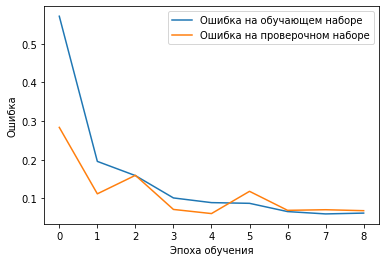

In [30]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

# Выводим легенду
plt.legend()
plt.show()

# **Окончательная проверка на тестовом массиве**

In [31]:
predict = model_ula.predict(x_test)[5000]
predict_inverse = y_scaler.inverse_transform(predict).flatten()
print(predict_inverse)
#orig = y_test[1000]
#y_test_inverse = y_scaler.inverse_transform(orig).flatten()
#print(y_test_inverse)

[773954.]


# **Средняя цена машины**

In [26]:
from statistics import mean 

print(round(mean(y_train_base), 2))


527726.1
